# 2. Text Extraction from Labelled Literature
This section will be focusing on the key objectives:
1. Read the Json file from the categorised data based on previous section with pickle file created - 1_scoped_cat_lit.pkl
2. Break down the Json file into sections as it is mapped from priority questions table
3. Begin performing Machine Learning preprocessing techniques such as vectorisation, bag of words, tfidf

In [33]:
# Include Appropriate libraries
import pandas as pd
from matplotlib import pyplot as plt
import json
from tqdm import tqdm

data_path = './551982_1230614_bundle_archive/'
priority_question_path = data_path + '/Kaggle/target_tables/2_relevant_factors/'

In [34]:
# Reading the pickle file generated by secion 1
scoped_categorised_literature = pd.read_pickle("./1_scoped_cat_lit.pkl")
scoped_categorised_literature.head(5)

,Date,topic_id,research_topic,pdf_json_files,pmc_json_files,Study,Study Link,Journal,Study Type,Factors,Influential,Excerpt,Measure of Evidence,Added on
1,2020-05-15,1,Effectiveness of a multifactorial strategy to ...,document_parses/pdf_json/c2ad6f8432bf7732ec8d0...,NaN,"A model for COVID-19 with isolation, quarantin...",https://arxiv.org/pdf/2005.07661v1.pdf,ArXiv,Modeling,"lockdown, social contact restriction",Y,"Comparing these four scenarios, we shall deduc...",Timeline: February 15th - May 6th,05/27/2020
2,2020-05-13,1,Effectiveness of a multifactorial strategy to ...,document_parses/pdf_json/f7ed51444c210f58c010f...,NaN,Modeling and forecasting of the COVID-19 pande...,https://arxiv.org/pdf/2005.07071v1.pdf,ArXiv,Modeling,"quarantine, lockdown, social distancing, isola...",Y,Our study reveals that the strict control meas...,Countries: India and seventeen states of India...,05/27/2020
3,2020-05-09,1,Effectiveness of a multifactorial strategy to ...,document_parses/pdf_json/a6bfd3583719947b0790e...,document_parses/pmc_json/PMC7210464.xml.json,Impacts of social and economic factors on the ...,https://doi.org/10.1007/s00148-020-00778-2,J Popul Econ,Modeling,"public health measures (social distancing, man...",Y,We then compare the transmission rates in diff...,Countries: China; Timeline: January 19 - Febru...,05/31/2020
4,2020-05-08,1,Effectiveness of a multifactorial strategy to ...,document_parses/pdf_json/9f1421f795084d05cda18...,document_parses/pmc_json/PMC7205920.xml.json,A multi-region discrete time mathematical mode...,https://doi.org/10.1007/s12190-020-01354-3,J Appl Math Comput,Modeling,"protecting susceptible individuals, preventing...",Y,Figure 10 shows that the number of the exposed...,-,05/28/2020
5,2020-05-06,1,Effectiveness of a multifactorial strategy to ...,document_parses/pdf_json/6e80241c8b6547c944ca0...,NaN,Now casting and Forecasting of COVID-19 outbre...,http://medrxiv.org/cgi/content/short/2020.05.0...,MedRxiv,Modeling Study,case isolation,Y,Lockdown showed highest reduction (28%) in num...,Countries: India; Timeline: -,05/30/2020


## 2.1. Observation - There's an in-balance of lablled data for different classes


Text(0, 0.5, 'Counts')

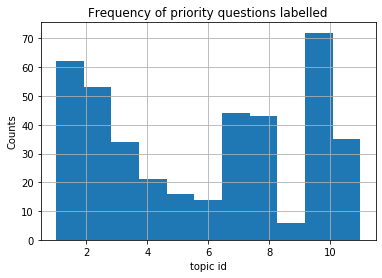

In [36]:
scoped_categorised_literature['topic_id'].plot.hist(grid=True, bins=11)
plt.title('Frequency of priority questions labelled')
plt.xlabel('topic id')
plt.ylabel('Counts')

## 2.2. Reading in the JSON file

In [37]:
# Testing with first JSOn file

json_path = scoped_categorised_literature.iloc[0]['pdf_json_files']
json_data = {}
with open(data_path + json_path) as f:
  json_data = json.load(f)
print(json_path)

document_parses/pdf_json/c2ad6f8432bf7732ec8d0fd32bfc07119bc20571.json


In [38]:
print(scoped_categorised_literature.iloc[0])

Date                                                          2020-05-15
topic_id                                                               1
research_topic         Effectiveness of a multifactorial strategy to ...
pdf_json_files         document_parses/pdf_json/c2ad6f8432bf7732ec8d0...
pmc_json_files                                                       NaN
Study                  A model for COVID-19 with isolation, quarantin...
Study Link                        https://arxiv.org/pdf/2005.07661v1.pdf
Journal                                                            ArXiv
Study Type                                                      Modeling
Factors                             lockdown, social contact restriction
Influential                                                            Y
Excerpt                Comparing these four scenarios, we shall deduc...
Measure of Evidence                    Timeline: February 15th - May 6th
Added on                                           

In [39]:
scoped_categorised_literature.iloc[2]['Excerpt']

'We then compare the transmission rates in different time windows. In the first sub-sample, one new infection leads to 2.135 more cases within a week, implying a fast growth in the number of cases. However, in the second sub-sample, the effect decreases to 1.077, suggesting that public health measures imposed in late January were effective in limiting a further spread of the virus.'

## 2.3. Json schema
Contains elements like metadata, bodytext , and many more

In [40]:
# Whole json file
print(json_data)

{'paper_id': 'c2ad6f8432bf7732ec8d0fd32bfc07119bc20571', 'metadata': {'title': 'A model for COVID-19 with isolation, quarantine and testing as control measures', 'authors': [{'first': 'M', 'middle': ['S'], 'last': 'Aronna', 'suffix': '', 'affiliation': {'laboratory': '', 'institution': 'FGV EMAp -Rio de Janeiro', 'location': {'country': 'Brazil'}}, 'email': ''}, {'first': 'R', 'middle': [], 'last': 'Guglielmi', 'suffix': '', 'affiliation': {'laboratory': '', 'institution': 'FGV EMAp -Rio de Janeiro', 'location': {'country': 'Brazil'}}, 'email': ''}, {'first': 'L', 'middle': ['M'], 'last': 'Moschen', 'suffix': '', 'affiliation': {'laboratory': '', 'institution': 'FGV EMAp -Rio de Janeiro', 'location': {'country': 'Brazil'}}, 'email': ''}]}, 'abstract': [{'text': 'In this article we propose a compartmental model for the dynamics of Coronavirus Disease 2019 . We take into account the presence of asymptomatic infections and the main policies that have been adopted so far to contain the epi

In [41]:
# Meta data
print(json_data['metadata'])

{'title': 'A model for COVID-19 with isolation, quarantine and testing as control measures', 'authors': [{'first': 'M', 'middle': ['S'], 'last': 'Aronna', 'suffix': '', 'affiliation': {'laboratory': '', 'institution': 'FGV EMAp -Rio de Janeiro', 'location': {'country': 'Brazil'}}, 'email': ''}, {'first': 'R', 'middle': [], 'last': 'Guglielmi', 'suffix': '', 'affiliation': {'laboratory': '', 'institution': 'FGV EMAp -Rio de Janeiro', 'location': {'country': 'Brazil'}}, 'email': ''}, {'first': 'L', 'middle': ['M'], 'last': 'Moschen', 'suffix': '', 'affiliation': {'laboratory': '', 'institution': 'FGV EMAp -Rio de Janeiro', 'location': {'country': 'Brazil'}}, 'email': ''}]}


In [42]:
print(json_data['metadata']['title'])

A model for COVID-19 with isolation, quarantine and testing as control measures


In [43]:
# Abstract data
# print(json_data['abstract'])

for abstract_text in json_data['abstract']:
    print(abstract_text['text'])

In this article we propose a compartmental model for the dynamics of Coronavirus Disease 2019 . We take into account the presence of asymptomatic infections and the main policies that have been adopted so far to contain the epidemic: isolation (or social distancing) of a portion of the population, quarantine for confirmed cases and testing. We model isolation by separating the population in two groups: one composed by key-workers that keep working during the pandemic and have a usual contact rate, and a second group consisting of people that are enforced/recommended to stay at home. We refer to quarantine as strict isolation, and it is applied to confirmed infected cases.
In the proposed model, the proportion of people in isolation, the level of contact reduction and the testing rate are control parameters that can vary in time, representing policies that evolve in different stages. We obtain an explicit expression for the basic reproduction number R 0 in terms of the parameters of the

In [44]:
# Body data
# print(json_data['body_text'])
for body_text in json_data['body_text']:
    print(body_text['section'])
    print(body_text['text'])
    print('______________________________________________')

Introduction
In late December 2019, several cases of an unknown pneumonia were identified in the city of Wuhan, Hubei province, China [23] . Some doctors of Wuhan conjectured that it could be severe acute respiratory syndrome (SARS) cases [24] . Many of the found cases had visited or were related to the Huanan Seafood Wholesale Market. On 31 December 2019, the World Health Organization (WHO) China Country Office was informed of these cases of pneumonia detected in Wuhan City and, up to 3 January 2020, a total of 44 patients with this unknown pneumonia were reported to WHO [30] . In the beginning of January 2020 Chinese officials ruled out the hypothesis that the cases were of SARS [17] , and a few days later the cause was identified to be a new coronavirus that was named SARS-CoV-2. The name given to the infectious disease caused by SARS-CoV-2 is COVID-19.
______________________________________________
Introduction
The first death due to COVID-19 was reported on 9 January and it was a 

## 2.4. Obtaining all body text data and save it into a dataframe
Note: Some rows references to multiple files within the pdf_json_files. Split by ;. For simplicity we will take the first json file
First, grab all the distinct json files from the scoped categorised_literature
Then, loop through the files and extract language data from the Json files

In [45]:
# obtaining the distinct list of pdf_json_data
# using set allows us to get distinct values and is more efficient
json_path_list = set();
for index, row in tqdm(scoped_categorised_literature.iterrows()):
    for json_path in row['pdf_json_files'].split(';'):
        #Using the strip function because there are spacings after splitting
        json_path_list.add(json_path.strip())
print(len(json_path_list))

400it [00:00, 16390.08it/s]

145


In [46]:
extract_json_path_list = []
extract_text_list = []
extract_section_list = []
extract_id_list = []
extract_id = 1
for json_path in tqdm(list(json_path_list)):
    abstract = ''
    with open(data_path + json_path) as f:
      json_data = json.load(f)
    # Extracting abstract from every literature
    for abstract_text in json_data['abstract']:
        abstract = abstract + abstract_text['text']
    extract_text_list.append(abstract)
    extract_section_list.append('abstract')
    extract_json_path_list.append(json_path)
    extract_id_list.append(extract_id)
    extract_id = extract_id + 1
    # Extracting body text from every literature
    for body_text in json_data['body_text']:
        extract_section_list.append(body_text['section'])
        extract_text_list.append(body_text['text']) 
        extract_json_path_list.append(json_path)
        extract_id_list.append(extract_id)
        extract_id = extract_id + 1

100%|██████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 1906.14it/s]


In [47]:
# Dimentional Check
print(len(extract_json_path_list), len(extract_text_list), len(extract_section_list), len(extract_id_list))

6496 6496 6496 6496


In [48]:
extracted_literature_data = pd.DataFrame(zip(extract_id_list, extract_json_path_list, extract_section_list, extract_text_list), columns = ['extract_id', 'json_path','section','text'])
print(extracted_literature_data)

      extract_id                                          json_path  \
0              1  document_parses/pdf_json/1715bd1d4f1bef50cdb5a...   
1              2  document_parses/pdf_json/1715bd1d4f1bef50cdb5a...   
2              3  document_parses/pdf_json/1715bd1d4f1bef50cdb5a...   
3              4  document_parses/pdf_json/1715bd1d4f1bef50cdb5a...   
4              5  document_parses/pdf_json/1715bd1d4f1bef50cdb5a...   
...          ...                                                ...   
6491        6492  document_parses/pdf_json/9f7d6699b9e91fe5b81a3...   
6492        6493  document_parses/pdf_json/9f7d6699b9e91fe5b81a3...   
6493        6494  document_parses/pdf_json/9f7d6699b9e91fe5b81a3...   
6494        6495  document_parses/pdf_json/9f7d6699b9e91fe5b81a3...   
6495        6496  document_parses/pdf_json/9f7d6699b9e91fe5b81a3...   

                                 section  \
0                               abstract   
1                           Introduction   
2              

## 2.5. Extract Segmentated Literature data into Pickle Data

In [49]:
extracted_literature_data.to_pickle("./2_extracted_literature_data.pkl")